In [87]:
# Copyright (c) 2026, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Example of a simple retrieval pipeline using nvidia/nemotron-colembed-vl-4b-v2 and Vidore V3

This notebook demonstrates a simple indexing and search pipeline of [nvidia/nemotron-colembed-vl-4b-v2](https://huggingface.co/nvidia/nemotron-colembed-vl-4b-v2) late-interaction embedding model using a dataset from the [Vidore V3 benchmark](https://huggingface.co/blog/QuentinJG/introducing-vidore-v3).  
Check more information about Nemotron ColEmbed v2 models in this [blog post](https://huggingface.co/blog/nvidia/nemotron-colembed-v2).

### Setup
**Install and import dependencies.**

In [ ]:
!pip install qwen_vl_utils -q
!pip install "accelerate>=1.1.0"
!pip install "transformers==5.0.0rc0"

In [4]:
import os, json
import pandas as pd
from datasets import load_dataset
import numpy as np
import io
from IPython.display import display, HTML
import base64

import torch
from transformers import AutoModel, AutoProcessor
from transformers.image_utils import load_image
from tqdm import tqdm
import numpy as np
import io
from PIL import Image

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading a Vidore V3 dataset

Vidore V3 tasks are composed by three dataset types: queries, corpus and qrels.

In [5]:
queries = load_dataset("vidore/vidore_v3_hr", "queries")
queries

Generating test split: 100%|██████████| 1908/1908 [00:00<00:00, 173163.09 examples/s]


DatasetDict({
    test: Dataset({
        features: ['query_id', 'query', 'language', 'query_types', 'query_format', 'content_type', 'raw_answers', 'query_generator', 'query_generation_pipeline', 'source_type', 'query_type_for_generation', 'answer'],
        num_rows: 1908
    })
})

In [6]:
queries['test'][0]

{'query_id': 0,
 'query': 'What impact did the shifts in temporary contract usage from 2018 to 2023 have on the difference in employment stability between mobile EU workers and citizens of the host countries?',
 'language': 'english',
 'query_types': ['multi-hop'],
 'query_format': 'question',
 'content_type': ['Chart', 'Table', 'Text'],
 'raw_answers': ['From 2018 to 2023, the job stability gap between mobile EU workers and nationals narrowed. The use of temporary contracts declined more for EU movers (from 19% to 14%) than for nationals (14% to 11%), reducing the difference between the two groups from 5 to 3 percentage points.'],
 'query_generator': 'sdg',
 'query_generation_pipeline': 'gretel',
 'source_type': 'summary',
 'query_type_for_generation': 'multi-hop',
 'answer': 'From 2018 to 2023, the job stability gap between mobile EU workers and nationals narrowed. The use of temporary contracts declined more for EU movers (from 19% to 14%) than for nationals (14% to 11%), reducing t

In [7]:
qrels = load_dataset("vidore/vidore_v3_hr", "qrels")
qrels

Generating test split: 100%|██████████| 10386/10386 [00:00<00:00, 1316193.05 examples/s]


DatasetDict({
    test: Dataset({
        features: ['query_id', 'corpus_id', 'score', 'content_type', 'bounding_boxes'],
        num_rows: 10386
    })
})

In [8]:
qrels['test'][0]

{'query_id': 0,
 'corpus_id': 372,
 'score': 1,
 'content_type': ['Text'],
 'bounding_boxes': [{'annotator': 0,
   'x1': 216,
   'x2': 1439,
   'y1': 802,
   'y2': 1013}]}

In [9]:
corpus = load_dataset("vidore/vidore_v3_hr", "corpus")
corpus

DatasetDict({
    test: Dataset({
        features: ['corpus_id', 'image', 'doc_id', 'markdown', 'page_number_in_doc'],
        num_rows: 1110
    })
})

In [10]:
corpus_df = corpus["test"].to_pandas()

In [11]:
def get_corpus_sample(corpus_idx):
    return corpus['test'][corpus_idx]

## Sampling a query

In [12]:
# Samples an arbitrary query
SAMPLED_QUERY_ID = 28
sampled_query = queries["test"][SAMPLED_QUERY_ID]
sampled_query

{'query_id': 28,
 'query': 'List the number of EU countries that ratified ILO Convention C189 by 2024 as mentioned in the text.',
 'language': 'english',
 'query_types': ['extractive', 'numerical'],
 'query_format': 'instruction',
 'content_type': ['Table', 'Text'],
 'raw_answers': ['The nine EU countries ratified ILO Convention C189 by 2024, as mentioned in the text.'],
 'query_generator': 'sdg',
 'query_generation_pipeline': 'custom_pipeline',
 'source_type': 'summary',
 'query_type_for_generation': 'extractive',
 'answer': 'Nine EU countries ratified ILO Convention C189 by 2024.'}

### Positive (ground-truth pages) from the sampled query
Lists the pages that have been annotated as relevant to the sampled query

In [13]:
# Positive pages
sampled_qrels = qrels['test'].filter(lambda x: x['query_id'] == SAMPLED_QUERY_ID).to_pandas().sort_values("score", ascending=False)
sampled_qrels

Filter: 100%|██████████| 10386/10386 [00:00<00:00, 60247.12 examples/s]


,query_id,corpus_id,score,content_type,bounding_boxes
3,28,310,2,[Text],"[{'annotator': 0, 'x1': 178, 'x2': 1479, 'y1':..."
0,28,255,1,[Text],"[{'annotator': 0, 'x1': 183, 'x2': 1520, 'y1':..."
1,28,261,1,"[Table, Text]","[{'annotator': 0, 'x1': 488, 'x2': 1445, 'y1':..."
2,28,304,1,[Text],"[{'annotator': 0, 'x1': 194, 'x2': 1472, 'y1':..."


In [14]:
def display_image_and_text(pil_image, text, pixels=800):
    buffered = io.BytesIO()
    pil_image.thumbnail((pixels, pixels))
    pil_image.save(buffered, format="PNG") # Save as PNG for universal web compatibility
    img_str = base64.b64encode(buffered.getvalue()).decode()
    img_html_src = f"data:image/png;base64,{img_str}"

    html_output = f"""
    <div>        
        <div style="float:left; width:50%;"><img src="{img_html_src}" alt="A PIL image"></div>
        <div style="float:left; width:50%;">{text}</div>
    </div>
    """

    display(HTML(html_output))


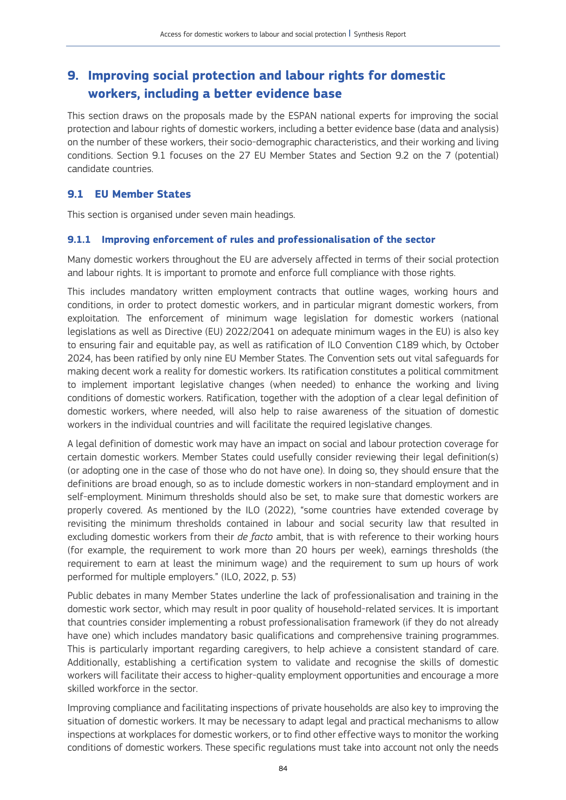


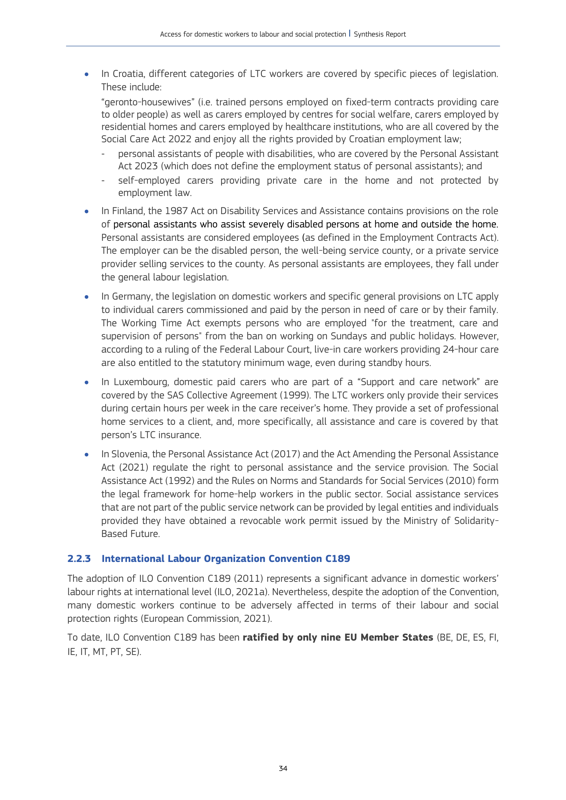


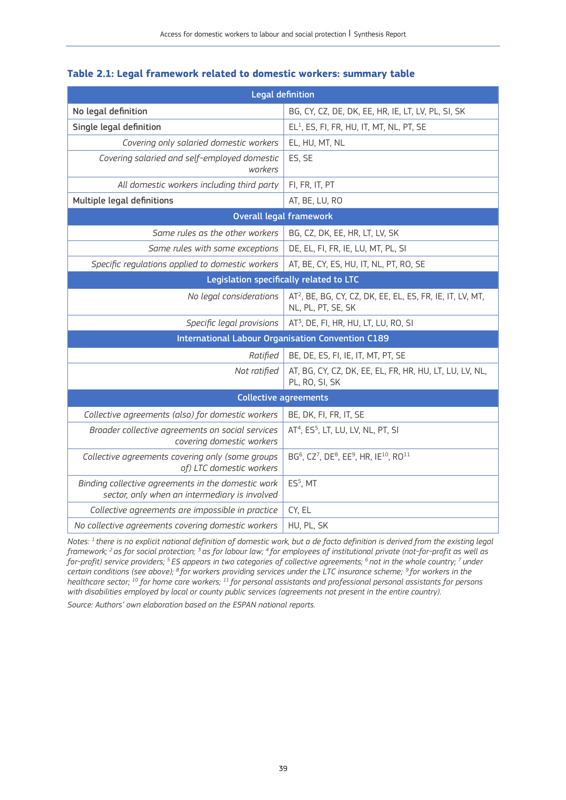


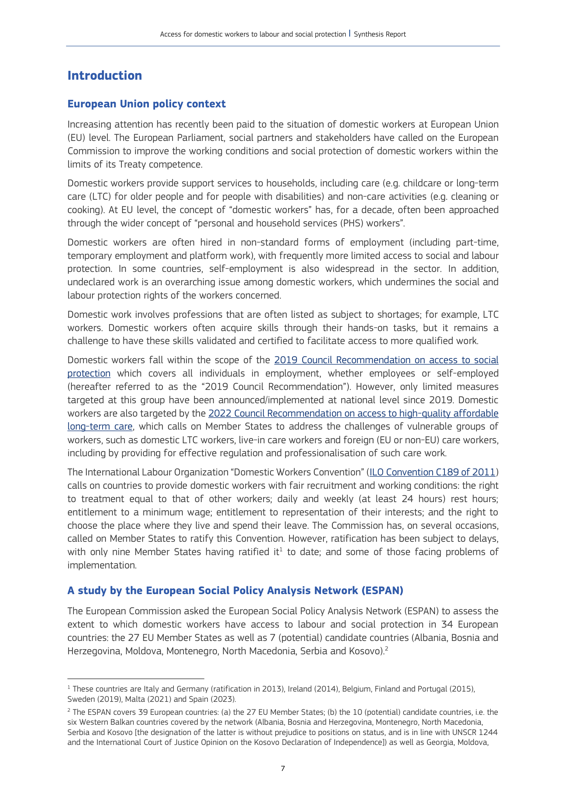

In [88]:
# Displays the relevant pages
for idx, row in sampled_qrels.iterrows():
    display(HTML(f'<p style="font-size: 16px; font-weight: bold;"> Query: {sampled_query["query"]}<br> <i> Answer: {sampled_query["answer"]}</i><br>'
                         f'<span style="color: blue;">Doc Id: {row["corpus_id"]} - Score: {row["score"]}</span></p>'))
    corpus_sample = corpus['test'][int(row["corpus_id"])]
    thumbnail_image = corpus_sample['image']
    text = '<p style="font-size: 10px; line-height: 1.3;">' + corpus_sample['markdown'].replace("\n", "<BR>") + '</p>' 
    display_image_and_text(thumbnail_image, text)
    print()
    print()

## Embedding the pages corpus

### Loads the model from HF Hub

In [16]:
model_name_or_path = "nvidia/nemotron-colembed-vl-4b-v2"
## You can also try ColEmbed VL 8b v2
#model_name_or_path = "nvidia/nemotron-colembed-vl-8b-v2"

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModel.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
    # FlashAttention 2 requires an NVIDIA GPU with Ampere micro-architecture or later. If not available, comment next line.
    attn_implementation="flash_attention_2",    
).eval()

Loading weights: 100%|██████████| 714/714 [00:02<00:00, 275.47it/s, Materializing param=model.visual.pos_embed.weight]                                 
The tied weights mapping and config for this model specifies to tie model.language_model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


### Embedding pages from their images

In [19]:
# Breaking pages into batches
BATCH_SIZE = 4
corpus_batches = [corpus_df[i:i + BATCH_SIZE] for i in range(0, len(corpus_df), BATCH_SIZE)]

In [ ]:
%%time
# Embedding pages from their image
page_image_embeddings_list = []
with torch.inference_mode():
    for batch in tqdm(corpus_batches):
        images = [Image.open(io.BytesIO(image_bytes["bytes"])) for image_bytes in batch['image']]
        embeddings = model.forward_images(images=images)
        page_image_embeddings_list.append(embeddings)
page_image_embeddings = torch.vstack(page_image_embeddings_list)
page_image_embeddings.shape

Uncomment the next cell to save the embeddings to disk as a numpy array if needed.

In [18]:
# page_image_embeddings_np = (
#     page_image_embeddings
#     .detach()
#     .cpu()
#     .float()        # ← convert bfloat16 → float32
#     .numpy()
# )
# np.save("page_image_embeddings.npy", page_image_embeddings_np)

## Retrieving pages for a query
Uses the embeddings to retrieves the top-k page images more relevant to the query

In [26]:
query = sampled_query["query"]
print(query)

# Embed the query
with torch.inference_mode():
    queries_embeddings = model.forward_queries([query] , batch_size=8)
queries_embeddings.shape

List the number of EU countries that ratified ILO Convention C189 by 2024 as mentioned in the text.


Extracting query embeddings...: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


torch.Size([1, 39, 2560])

### Retrieve pages

In [82]:
def get_sorted_top_k_retrieved_corpus_ids(docs_embeddings):
    device = next(model.parameters()).device
    # Computes MaxSim between the query embeddings and document embeddings
    sim_scores = model.get_scores(queries_embeddings, docs_embeddings)
    
    # Flatten logits to 1D array (handle both [batch_size] and [batch_size, 1] shapes)
    sim_scores_flat = sim_scores.flatten()
        
    # Get sorted indices (highest to lowest)
    sorted_indices = torch.argsort(sim_scores_flat, descending=True).cpu().numpy()
    sorted_sim_scores = sim_scores_flat[sorted_indices].cpu().float().numpy()

    return sorted_indices, sorted_sim_scores

In [83]:
def display_retrieved_pages(retrieved_docs_df, topk=5, max_pixels=800):
    for idx, row in retrieved_docs_df[:topk].iterrows():
        display(HTML(f'<p style="font-size: 16px; font-weight: bold;"> Query: {sampled_query["query"]}<br> <i>Answer: {sampled_query["answer"]}</i><br><br>'
                            f'<span style="color: {"blue" if int(row["doc_id"]) in sampled_qrels["corpus_id"].values else "red"};">Doc Id: {int(row["doc_id"])} - Score: {row["score"]}</span></p>'))
        corpus_sample = get_corpus_sample(int(row["doc_id"]))
        thumbnail_image = corpus_sample['image']
        text = '<p style="font-size: 10px; line-height: 1.3;">' + corpus_sample['markdown'].replace("\n", "<BR>") + '</p>' 
        display_image_and_text(thumbnail_image, text, pixels=max_pixels)
        print()
        print()

In [90]:
sorted_indices_retrieved_pages_by_images, sorted_cos_sim_retrieved_pages_by_images = \
                    get_sorted_top_k_retrieved_corpus_ids(page_image_embeddings)
sorted_indices_retrieved_pages_by_images[:5]

array([255, 310, 231, 304, 686])

In [72]:
retrieved_docs_by_image_df = pd.DataFrame({"doc_id": sorted_indices_retrieved_pages_by_images, 
                                           "score": sorted_cos_sim_retrieved_pages_by_images
                                 })
retrieved_docs_by_image_df[:10]

,doc_id,score
0,255,36.468807
1,310,36.297958
2,231,36.109818
3,304,36.083572
4,686,35.908669
5,300,35.900711
6,261,35.867767
7,685,35.849392
8,235,35.824432
9,230,35.741138


In [ ]:
def recall_at_k(retrieved_top_k, gt_pages, topk=5):
    return len(set(retrieved_top_k[:topk]).intersection(set(gt_pages))) / len(gt_pages)

In [81]:
recall_image_retrieval = recall_at_k(sorted_indices_retrieved_pages_by_images, gt_pages=sampled_qrels['corpus_id'], topk=5)
print(f"Recall@5 retrieving pages by image: {recall_image_retrieval}")

Recall@5 retrieving pages by image: 0.75


### Displaying top-5 retrieved pages
(positive pages in <span style="color: blue">blue</span>, negative pages in <span style="color: red">red</span>)


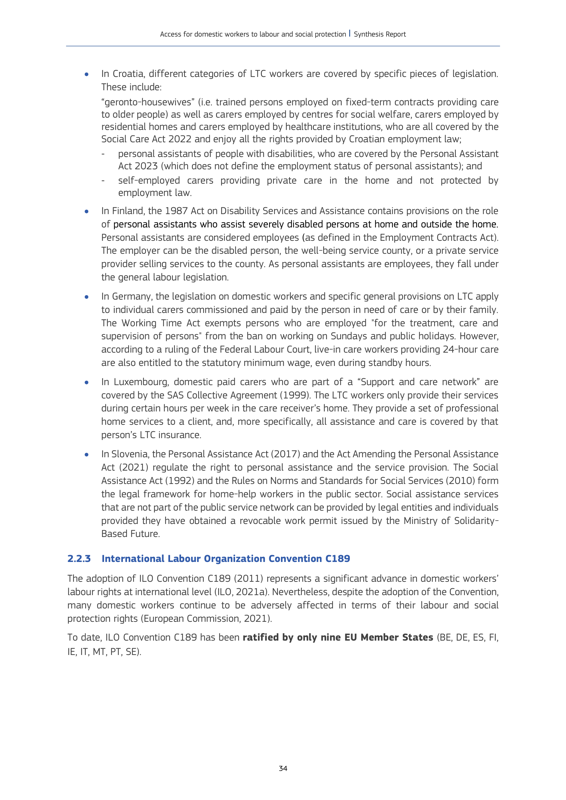


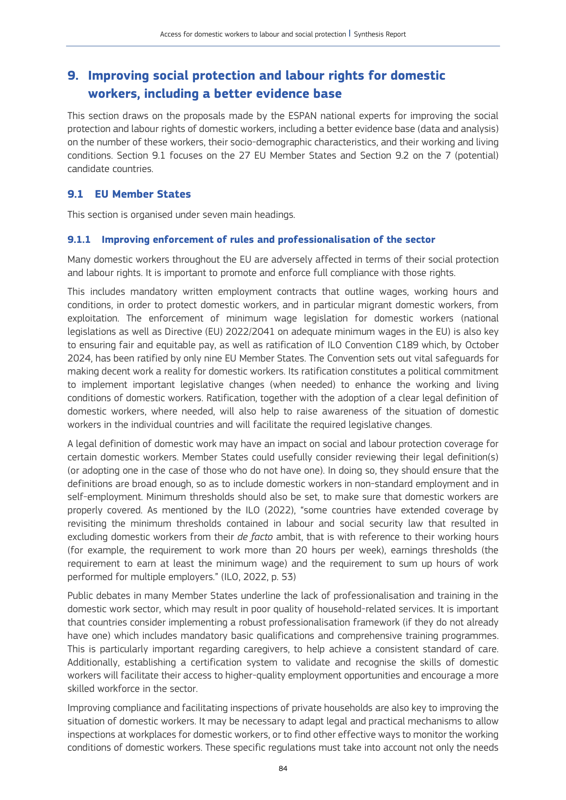


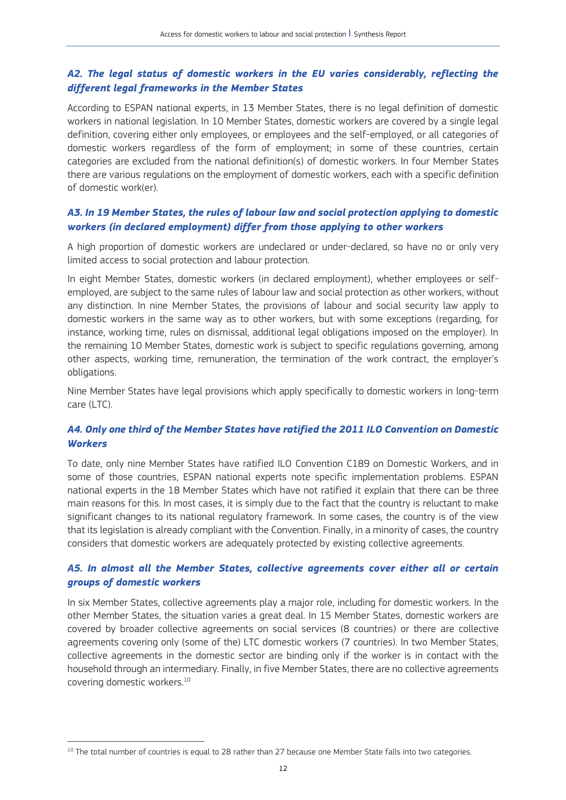


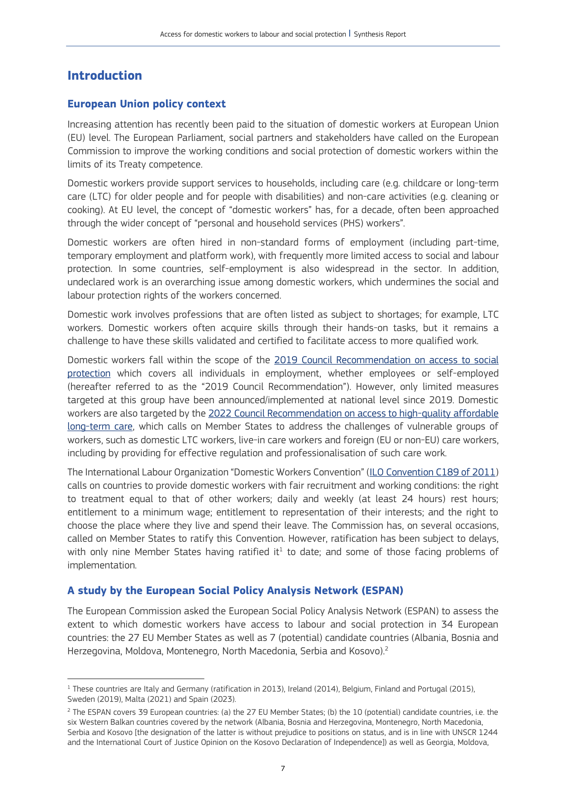


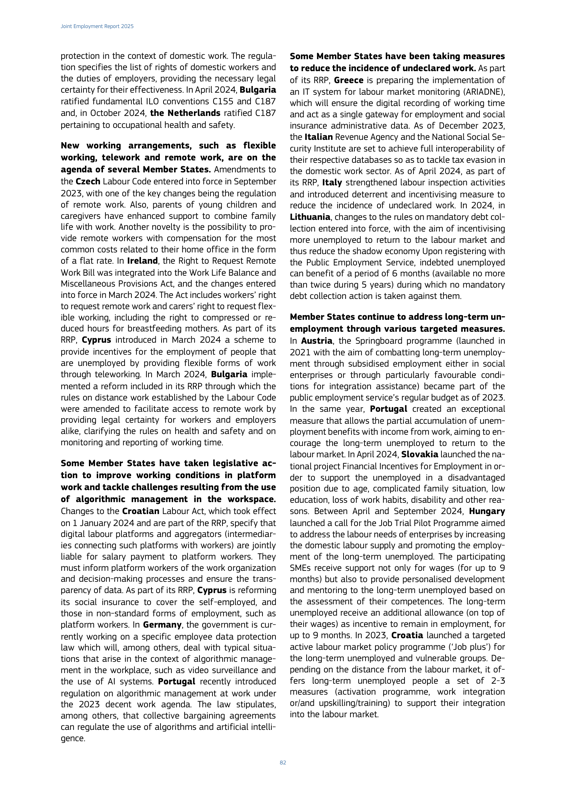

In [76]:
display_retrieved_pages(retrieved_docs_by_image_df)